In [10]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import dataloader_tf
import importlib
from subpixel import subpix_conv2d

In [20]:
#dataloader_tf.convert_data(path = './data/nyu_depth_v2_labeled.mat',save_to = './data/')

In [11]:
default_activation = tf.nn.leaky_relu
def redefine_loss(logits, depths):
    logits_flat = tf.reshape(logits, [-1, 55*74])
    depths_flat = tf.reshape(depths, [-1, 55*74])
    predict=logits_flat
    target=depths_flat
    d = tf.subtract(predict, target)
    square_d = tf.square(d)
    sum_square_d = tf.reduce_sum(square_d, 1)
    sum_d = tf.reduce_sum(d, 1)
    sqare_sum_d = tf.square(sum_d)
    cost = tf.reduce_mean(sum_square_d / (55.0*74.0) - 0.5*sqare_sum_d / (55*74)**2)
    return cost 
def accuracy(logits, depths, delta=1.25):
    return tf.reduce_mean(tf.cast(tf.maximum(tf.subtract(logits, depths), tf.subtract(depths, logits))<tf.log(delta), tf.float32))
def normalize(image):
    img = image-np.min(image)
    return (img)/np.max(img)

In [3]:
'''
def conv_layer(image):
    # Hidden layer with 96 neurons
    layer_1 = tf.layers.conv2d(image,filters=96,kernel_size=[11,11],strides=4,padding='VALID',activation=default_activation,name='CoarseConv1')
    layer_1 = tf.layers.max_pooling2d(layer_1,pool_size=2,strides=2,name='CoarseMax1')
    #layer_1 = tf.layers.batch_normalization(layer_1, training=is_training, name='CoarseConvBN1')
    
    # Hidden layer with 256 neurons
    layer_2 = tf.layers.conv2d(layer_1,filters=256,kernel_size=[5,5],strides=1,padding='SAME',activation=default_activation,name='CoarseConv2')
    layer_2 = tf.layers.max_pooling2d(layer_2,pool_size=[2,2],strides=2,name='CoarseMax2')
    #layer_2 = tf.layers.batch_normalization(layer_2, training=is_training, name='CoarseConvBN2')
    
    layer_3 = tf.layers.conv2d(layer_2,filters=384,kernel_size=[3,3],strides=1,padding='SAME',activation=default_activation,name='CoarseConv3')
    #layer_3 = tf.layers.batch_normalization(layer_3, training=is_training, name='CoarseConvBN3')
    
    layer_4 = tf.layers.conv2d(layer_3,filters=384,kernel_size=[3,3],strides=1,padding='SAME',activation=default_activation,name='CoarseConv4')
    #layer_4 = tf.layers.batch_normalization(layer_4, training=is_training, name='CoarseConvBN4')
    layer_5 = tf.layers.conv2d(layer_4,filters=256,kernel_size=[3,3],strides=2,padding='VALID',activation=default_activation,name='CoarseConv5')
    #layer_5 = tf.layers.batch_normalization(layer_5, training=is_training, name='CoarseConvBN5')
    return layer_5

def fully_connect_layer(conv_data,dropout,is_training):
    conv_data = tf.reshape(conv_data,[-1,conv_data.shape[1]*conv_data.shape[2]*conv_data.shape[3]])
    
    layer_1 = tf.layers.dense(conv_data,units=4096,activation=default_activation,name='CoarseFC1')
    #layer_1 = tf.layers.batch_normalization(layer_1, training=is_training, name='CoarseFCBN1')
    layer_1 = tf.layers.dropout(layer_1,rate=dropout,training=is_training,name='CoarseFCDrop1')
    
    layer_2 = tf.layers.dense(layer_1,units=4070,activation=None,name='CoarseFC2')
    #layer_2 = tf.layers.batch_normalization(layer_2, training=is_training, name='CoarseFCBN2')
    out_layer = tf.reshape(layer_2,[-1,55,74,1])
    return out_layer
'''

"\ndef conv_layer(image):\n    # Hidden layer with 96 neurons\n    layer_1 = tf.layers.conv2d(image,filters=96,kernel_size=[11,11],strides=4,padding='VALID',activation=default_activation,name='CoarseConv1')\n    layer_1 = tf.layers.max_pooling2d(layer_1,pool_size=2,strides=2,name='CoarseMax1')\n    #layer_1 = tf.layers.batch_normalization(layer_1, training=is_training, name='CoarseConvBN1')\n    \n    # Hidden layer with 256 neurons\n    layer_2 = tf.layers.conv2d(layer_1,filters=256,kernel_size=[5,5],strides=1,padding='SAME',activation=default_activation,name='CoarseConv2')\n    layer_2 = tf.layers.max_pooling2d(layer_2,pool_size=[2,2],strides=2,name='CoarseMax2')\n    #layer_2 = tf.layers.batch_normalization(layer_2, training=is_training, name='CoarseConvBN2')\n    \n    layer_3 = tf.layers.conv2d(layer_2,filters=384,kernel_size=[3,3],strides=1,padding='SAME',activation=default_activation,name='CoarseConv3')\n    #layer_3 = tf.layers.batch_normalization(layer_3, training=is_training,

In [12]:

def downsample_layer(image):
    # Hidden layer with 76 * 57 * 64
    layer_1 = tf.layers.conv2d(image,filters=64,kernel_size=[7,7],strides=2,padding='VALID',activation=default_activation,name='Coarse1Conv1')
    layer_1 = tf.layers.batch_normalization(layer_1, training=is_training, name='Coarse1ConvBN1')
    max_pool1 = tf.layers.max_pooling2d(layer_1,pool_size=3,strides=2,name='Coarse1Max1')
    #print(np.shape(max_pool1))
    #Second block
    layer_2 = tf.layers.conv2d(max_pool1,filters=256,kernel_size=[1,1],strides=1,padding='VALID',activation=default_activation,name='Coarse1Conv2')
    layer_2 = tf.layers.batch_normalization(layer_2, training=is_training, name='Coarse1ConvBN2')
    #print(np.shape(layer_2))
    #Firt projection branch
    branch_1 = tf.layers.conv2d(max_pool1,filters=64,kernel_size=[1,1],strides=1,padding='VALID',activation=default_activation,name='Branch1Conv1')
    branch_1 = tf.layers.batch_normalization(branch_1, training=is_training, name='Branch1ConvBN1')
    #print(np.shape(branch_1))
    branch_1 = tf.layers.conv2d(branch_1,filters=64,kernel_size=[3,3],strides=1,padding='SAME',activation=default_activation,name='Branch1Conv2')
    branch_1 = tf.layers.batch_normalization(branch_1, training=is_training, name='Branch1ConvBN2')
    #print(np.shape(branch_1))
    branch_1 = tf.layers.conv2d(branch_1,filters=256,kernel_size=[1,1],strides=1,padding='SAME',activation=default_activation,name='Branch1Conv3')
    branch_1 = tf.layers.batch_normalization(branch_1, training=is_training, name='Branch1ConvBN3')
    #print(np.shape(branch_1))
    #concate  *******no relu
    concate_1 = tf.concat([layer_2,branch_1],name = 'Concate1',axis=3)
    
    concate_1 = tf.nn.leaky_relu(concate_1)
    #Second projection branch
    branch_2 = tf.layers.conv2d(concate_1,filters=64,kernel_size=[1,1],strides=1,padding='VALID',activation=default_activation,name='Branch2Conv1')
    branch_2 = tf.layers.batch_normalization(branch_2, training=is_training, name='Branch2ConvBN1')
    #print(np.shape(branch_2))
    branch_2 = tf.layers.conv2d(branch_2,filters=64,kernel_size=[3,3],strides=1,padding='SAME',activation=default_activation,name='Branch2Conv2')
    branch_2 = tf.layers.batch_normalization(branch_2, training=is_training, name='Branch2ConvBN2')
    #print(np.shape(branch_2))
    branch_2 = tf.layers.conv2d(branch_2,filters=256,kernel_size=[1,1],strides=1,padding='SAME',activation=default_activation,name='Branch2Conv3')
    branch_2 = tf.layers.batch_normalization(branch_2, training=is_training, name='Branch2ConvBN3')
    #print(np.shape(branch_2))
    #concate
    concate_2 = tf.concat([concate_1,branch_2],name = 'Concate2',axis=3)
    concate_2 = tf.nn.leaky_relu(concate_2)
    # Third projection branch
    branch_3 = tf.layers.conv2d(concate_2,filters=64,kernel_size=[1,1],strides=1,padding='VALID',activation=default_activation,name='Branch3Conv1')
    branch_3 = tf.layers.batch_normalization(branch_3, training=is_training, name='Branch3ConvBN1')
    branch_3 = tf.layers.conv2d(branch_3,filters=64,kernel_size=[3,3],strides=1,padding='SAME',activation=default_activation,name='Branch3Conv2')
    branch_3 = tf.layers.batch_normalization(branch_3, training=is_training, name='Branch3ConvBN2')
    branch_3 = tf.layers.conv2d(branch_3,filters=256,kernel_size=[1,1],strides=1,padding='SAME',activation=default_activation,name='Branch3Conv3')
    branch_3 = tf.layers.batch_normalization(branch_3, training=is_training, name='Branch3ConvBN3')
 
    # concate
    concate_3 = tf.concat([concate_2,branch_3],name = 'Concate3',axis=3)
    concate_3 = tf.nn.leaky_relu(concate_3)
    #print(concate_3)
    
    #Fourth branch
    branch_4 = tf.layers.conv2d(concate_3,filters=512,kernel_size=[1,1],strides=2,padding='SAME',activation=default_activation,name='Branch4Conv1')
    branch_4 = tf.layers.batch_normalization(branch_4, training=is_training, name='Branch4ConvBN1')
    
    #print(np.shape(branch_4))

    # Fifth branch
    branch_5 = tf.layers.conv2d(concate_3,filters=128,kernel_size=[1,1],strides=2,padding='VALID',activation=default_activation,name='Branch5Conv1')
    branch_5 = tf.layers.batch_normalization(branch_5, training=is_training, name='Branch5ConvBN1')
    #print(np.shape(branch_5))
    branch_5 = tf.layers.conv2d(branch_5,filters=128,kernel_size=[3,3],strides=1,padding='SAME',activation=default_activation,name='Branch5Conv2')
    branch_5 = tf.layers.batch_normalization(branch_5, training=is_training, name='Branch5ConvBN2')
    #print(np.shape(branch_5))
    branch_5 = tf.layers.conv2d(branch_5,filters=512,kernel_size=[1,1],strides=1,padding='SAME',activation=default_activation,name='Branch5Conv3')
    branch_5 = tf.layers.batch_normalization(branch_5, training=is_training, name='Branch5ConvBN3')
    #print(np.shape(branch_5))
    #Concate
    
    concate_4 = tf.concat([branch_4,branch_5],name = 'Concate4',axis=3)
    concate_4 = tf.nn.leaky_relu(concate_4)
    print(np.shape(concate_4))
    
    #Sixth branch
    branch_6 = tf.layers.conv2d(concate_4,filters=128,kernel_size=[1,1],strides=1,padding='VALID',activation=default_activation,name='Branch6Conv1')
    branch_6 = tf.layers.batch_normalization(branch_6, training=is_training, name='Branch6ConvBN1')
    print(np.shape(branch_6))
    branch_6 = tf.layers.conv2d(branch_6,filters=128,kernel_size=[3,3],strides=1,padding='SAME',activation=default_activation,name='Branch6Conv2')
    branch_6 = tf.layers.batch_normalization(branch_6, training=is_training, name='Branch6ConvBN2')
    print(np.shape(branch_6))
    branch_6 = tf.layers.conv2d(branch_6,filters=512,kernel_size=[1,1],strides=1,padding='SAME',activation=default_activation,name='Branch6Conv3')
    branch_6 = tf.layers.batch_normalization(branch_6, training=is_training, name='Branch6ConvBN3')
    print(np.shape(branch_6))
    #Concate
    concate_5 = tf.concat([concate_4,branch_6],name = 'Concate5',axis=3)
    concate_5 = tf.nn.leaky_relu(concate_5)
    
    #Seventh branch
    branch_7 = tf.layers.conv2d(concate_5,filters=128,kernel_size=[1,1],strides=1,padding='VALID',activation=default_activation,name='Branch7Conv1')
    branch_7 = tf.layers.batch_normalization(branch_7, training=is_training, name='Branch7ConvBN1')
    branch_7 = tf.layers.conv2d(branch_7,filters=128,kernel_size=[3,3],strides=1,padding='SAME',activation=default_activation,name='Branch7Conv2')
    branch_7 = tf.layers.batch_normalization(branch_7, training=is_training, name='Branch7ConvBN2')
    branch_7 = tf.layers.conv2d(branch_7,filters=512,kernel_size=[1,1],strides=1,padding='SAME',activation=default_activation,name='Branch7Conv3')
    branch_7 = tf.layers.batch_normalization(branch_7, training=is_training, name='Branch7ConvBN3')
    
    print(np.shape(branch_7))
    
    branch_8 = tf.layers.conv2d(branch_7,filters=256,kernel_size=[3,3],strides=3,padding='VALID',activation=default_activation,name='Branch8Conv1')
    branch_8 = tf.layers.batch_normalization(branch_8, training=is_training, name='Branch8ConvBN1')


    
    return branch_8

def fully_connect_layer(conv_data,dropout,is_training):
    conv_data = tf.reshape(conv_data,[-1,conv_data.shape[1]*conv_data.shape[2]*conv_data.shape[3]])
    
    layer_1 = tf.layers.dense(conv_data,units=4096,activation=default_activation,name='CoarseFC1')
    #layer_1 = tf.layers.batch_normalization(layer_1, training=is_training, name='CoarseFCBN1')
    layer_1 = tf.layers.dropout(layer_1,rate=dropout,training=is_training,name='CoarseFCDrop1')
    
    layer_2 = tf.layers.dense(layer_1,units=4070,activation=None,name='CoarseFC2')
    #layer_2 = tf.layers.batch_normalization(layer_2, training=is_training, name='CoarseFCBN2')
    out_layer = tf.reshape(layer_2,[-1,55,74,1])
    return out_layer


In [13]:
def coarse(image, dropout, is_training):
    conv_data = downsample_layer(image) #6x8x256
    coarse = fully_connect_layer(conv_data,dropout,is_training)
#     coarse = subpix_conv2d(conv_data, 128, (5,5), 3)
#     coarse = subpix_conv2d(coarse, 64, (5,5), 3)
#     coarse = tf.layers.conv2d_transpose(coarse, 1, (2,3), 1)
    return coarse #74x55x1

In [14]:
def fine(image, coarse, fine_gate, dropout, is_training):
    coarse = tf.cond(fine_gate, lambda : tf.stop_gradient(coarse), lambda : coarse)
    layer_1 = tf.layers.conv2d(image,filters=63,kernel_size=[9,9],strides=2,padding='VALID',activation=default_activation,name='FineConv1')
    layer_1 = tf.layers.max_pooling2d(layer_1,pool_size=[2,2],strides=2,data_format='channels_last',name='FineMax1')
    #layer_1 = tf.layers.batch_normalization(layer_1, training=is_training, name='FineBN1')

    catted = tf.concat([layer_1,coarse],axis=3, name='Fine1to2')
    layer_3 = tf.layers.conv2d(catted,filters=64,kernel_size=[5,5],strides=1,padding='SAME',activation=default_activation,name='FineConv2')
    #layer_3 = tf.layers.batch_normalization(layer_3, training=is_training, name='FineBN2')
    layer_4 = tf.layers.conv2d(layer_3,filters=1,kernel_size=[5,5],strides=1,padding='SAME',activation=default_activation,name='FineConv3')
    #layer_4 = tf.layers.batch_normalization(layer_4, training=is_training, name='FineBN3')
    
    out = tf.cond(is_training,
                  lambda : tf.cond(fine_gate, lambda : layer_4, lambda : 0.1*layer_4+0.9*coarse),
                  lambda : layer_4)
    return out


In [15]:
def augment(images,depths,crop_size,scale_range,rot_range,flip):
    catted = tf.concat([images, depths], axis=3)
    s = tf.random_uniform([], *scale_range)
    scaled = catted
    #scaled = tf.image.resize_images(catted, tf.cast(tf.cast(tf.shape(catted)[1:3], tf.float32)*s, tf.int32))
    # scaled = tf.concat([scaled[...,:-1], tf.divide(scaled[...,-1:], s)], axis=3)
    #rotated = tf.contrib.image.rotate(scaled, tf.random_uniform([tf.shape(scaled)[0],], *rot_range)/180*3.14159265)
    rotated = scaled
    cropped = tf.map_fn(lambda img: tf.random_crop(img, (crop_size[0], crop_size[1], catted.shape[3])), rotated)
    if flip:
        out = tf.map_fn(lambda img: tf.image.random_flip_left_right(img), cropped)
    else:
        out = cropped
    return out[...,0:3], out[...,3:]

def preprocess(images, depths, crop_size, depth_size=(55,74), scale_range=(0.5,1.5), rot_range=(-5,5), flip=True):
    image,depth = augment(images, depths, crop_size, scale_range, rot_range, flip)
    depth = tf.image.resize_images(depth, depth_size)
    return image/255, tf.log(depth)

In [20]:
INIT_LR = 0.0001
DECAY_SPEED = 1/20

tf.reset_default_graph() 

global_step = tf.Variable(0.0, trainable=False)

with tf.name_scope('Reader'):
    train_reader, test_reader = dataloader_tf.load_data(traindata='./data/NYUv2_train.tfrecords',testdata = './data/NYUv2_test.tfrecords')
    #reader = Loader(imagepath='./data/nyu_datasets/*.jpg', depthpath='./data/nyu_datasets/*.png', batch_size=4, seed=0)
    train_img_reader, train_depth_reader = train_reader
    test_img_reader, test_depth_reader = test_reader
    train_img_reader,test_img_reader = tf.cast(train_img_reader,tf.float32),tf.cast(test_img_reader,tf.float32)
with tf.name_scope('Preprocess'):
    train_imgs, train_depths = preprocess(train_img_reader, train_depth_reader, crop_size=[228,304], depth_size=[55,74])
    test_imgs, test_depths = preprocess(test_img_reader, test_depth_reader, crop_size=[228,304], depth_size=[55,74], scale_range=(0.475,0.475), rot_range=(0,0), flip=False)
with tf.name_scope('Parameters'):
    fine_gate = tf.placeholder_with_default(True,shape=[])
    learning_rate = INIT_LR/(1+DECAY_SPEED*global_step)
    is_training = tf.placeholder_with_default(False, [])
with tf.name_scope('Model'):
    img_input = tf.placeholder(tf.float32,[None,228,304,3])
    depth_input = tf.placeholder(tf.float32,[None,55,74,1])
    coarse_output = coarse(img_input, 0.3, is_training)
    refined_output = fine(img_input, coarse_output, fine_gate, 0.3, is_training)
with tf.name_scope('Loss'):
    loss_op = redefine_loss(refined_output, depth_input)
with tf.name_scope('Adam'):
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    with tf.control_dependencies(update_ops):
        train_op = optimizer.minimize(loss_op)
with tf.name_scope('Accuracy'):
    accuracy_op = accuracy(refined_output, depth_input, 1.25)

running_loss_sum = tf.placeholder(tf.float32, [])
running_accuracy_sum = tf.placeholder(tf.float32, [])
input_image_sum = tf.placeholder(tf.float32, [1,228,304,3])
input_depth_sum = tf.placeholder(tf.float32, [1,55,74,1])
coarse_sum = tf.placeholder(tf.float32, [1,55,74,1])
refined_sum = tf.placeholder(tf.float32, [1,55,74,1])

train_summary = tf.summary.merge([
    tf.summary.scalar('train_running_loss', running_loss_sum),
    tf.summary.scalar('train_running_accuracy', running_accuracy_sum),
    tf.summary.scalar('learning_rate', learning_rate),
    tf.summary.image('train_input', input_image_sum),
    tf.summary.image('train_target', input_depth_sum),
    tf.summary.image('train_coarse', coarse_sum),
    tf.summary.image('train_output', refined_sum)
])
test_summary = tf.summary.merge([
    tf.summary.scalar('test_loss', running_loss_sum),
    tf.summary.scalar('test_accuracy', running_accuracy_sum),
    tf.summary.image('test_input', input_image_sum),
    tf.summary.image('test_target', input_depth_sum),
    tf.summary.image('test_coarse', coarse_sum),
    tf.summary.image('test_output', refined_sum)
])


(?, 28, 37, 1024)
(?, 28, 37, 128)
(?, 28, 37, 128)
(?, 28, 37, 512)
(?, 28, 37, 512)


INFO:tensorflow:Restoring parameters from ./logs/BN_FCRN_augment_depth_0003/CSE291FinalModel.ckpt-350
Checkpoint recovered ./logs/BN_FCRN_augment_depth_0003/CSE291FinalModel.ckpt-350
351.0 

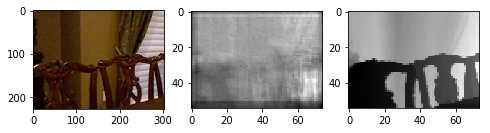

Train loss: 0.130404121371 Train accauacy: 0.393712200568 Test loss: 0.123423613608 Test acc: 0.422373117879
352.0 

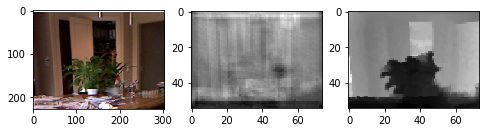

Train loss: 0.129539707532 Train accauacy: 0.401292288876 Test loss: 0.124907851801 Test acc: 0.397614021786
353.0 

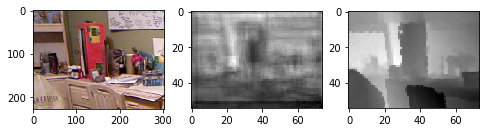

Train loss: 0.135079807845 Train accauacy: 0.393320497183 Test loss: 0.120375417173 Test acc: 0.406742359512
354.0 

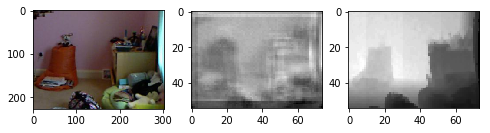

Train loss: 0.131596088983 Train accauacy: 0.401847005464 Test loss: 0.128108178265 Test acc: 0.381973664276
355.0 

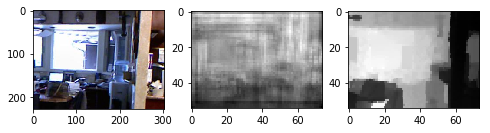

Train loss: 0.124385481471 Train accauacy: 0.410329569303 Test loss: 0.119727921672 Test acc: 0.402029904071
356.0 

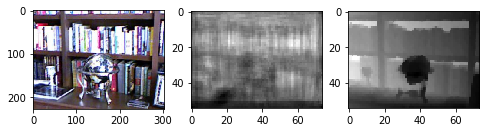

Train loss: 0.125586528159 Train accauacy: 0.410273106052 Test loss: 0.117621585145 Test acc: 0.42693585204
357.0 

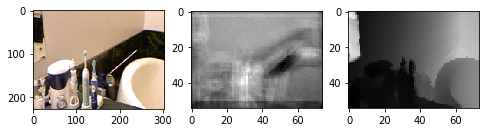

Train loss: 0.131353179136 Train accauacy: 0.396284493345 Test loss: 0.124472717987 Test acc: 0.413020194508
358.0 

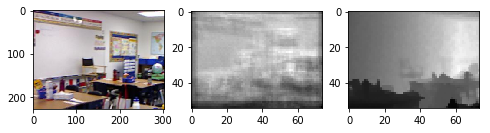

Train loss: 0.130328151784 Train accauacy: 0.403281044731 Test loss: 0.115292032249 Test acc: 0.434217600152
359.0 

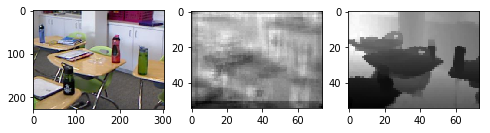

Train loss: 0.125925635776 Train accauacy: 0.409408429609 Test loss: 0.117155545857 Test acc: 0.440064494032
360.0 

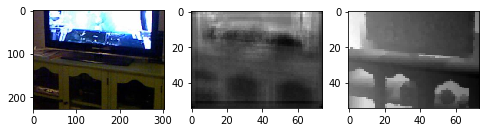

Train loss: 0.126595043219 Train accauacy: 0.404324322996 Test loss: 0.120014727348 Test acc: 0.435359723866
361.0 

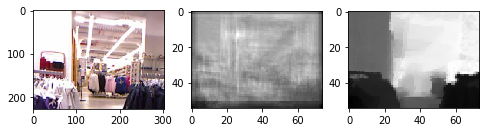

Train loss: 0.125592806334 Train accauacy: 0.400966972227 Test loss: 0.132510420633 Test acc: 0.397744549438
362.0 

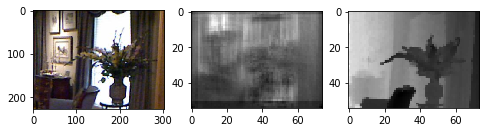

Train loss: 0.127518526465 Train accauacy: 0.396403799378 Test loss: 0.119538434199 Test acc: 0.429757556878
363.0 

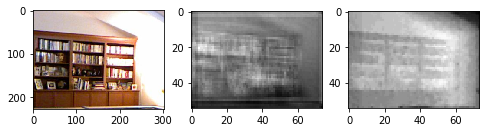

Train loss: 0.134217585709 Train accauacy: 0.384926053079 Test loss: 0.122820369434 Test acc: 0.419122387655
364.0 

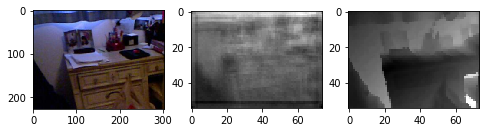

Train loss: 0.128770652786 Train accauacy: 0.392536382377 Test loss: 0.122897903901 Test acc: 0.397827090696
365.0 

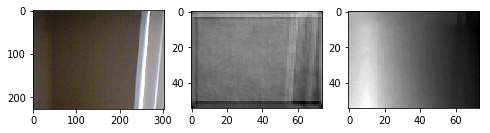

Train loss: 0.12261587539 Train accauacy: 0.41201946701 Test loss: 0.13342595892 Test acc: 0.376309121493
366.0 

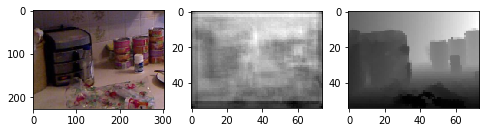

Train loss: 0.12415181258 Train accauacy: 0.40755221156 Test loss: 0.114006581018 Test acc: 0.43659973843
367.0 

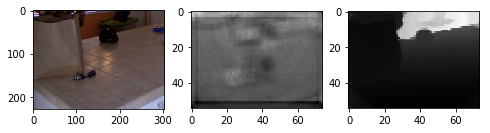

Train loss: 0.125947749844 Train accauacy: 0.404469619691 Test loss: 0.112593623577 Test acc: 0.434928784147
368.0 

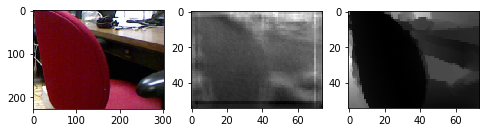

Train loss: 0.128139249579 Train accauacy: 0.4036342383 Test loss: 0.115712231142 Test acc: 0.430161625613
369.0 

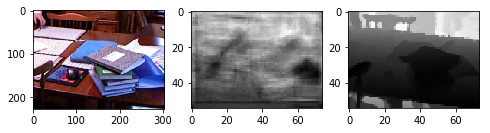

Train loss: 0.123175390466 Train accauacy: 0.412013560247 Test loss: 0.113594171009 Test acc: 0.42563536996
370.0 

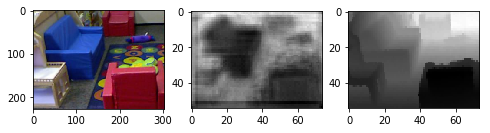

Train loss: 0.125436252613 Train accauacy: 0.398576828837 Test loss: 0.119833349716 Test acc: 0.43087089574
371.0 

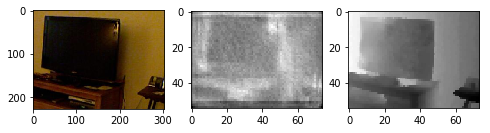

Train loss: 0.119146973726 Train accauacy: 0.415737809871 Test loss: 0.119425525772 Test acc: 0.424236026127
372.0 

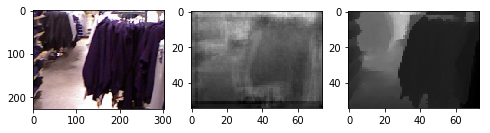

Train loss: 0.125343593497 Train accauacy: 0.407822008431 Test loss: 0.110340643907 Test acc: 0.45498118829
373.0 

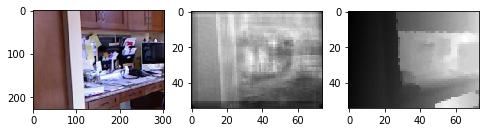

Train loss: 0.127724038437 Train accauacy: 0.396176998776 Test loss: 0.122199253412 Test acc: 0.428682624362
374.0 

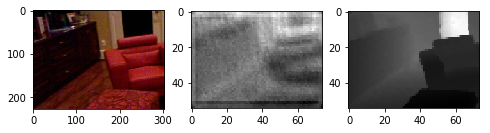

Train loss: 0.125198794242 Train accauacy: 0.401968437662 Test loss: 0.116967733949 Test acc: 0.441482070833
375.0 

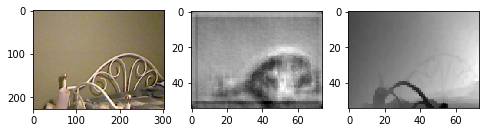

Train loss: 0.127460369697 Train accauacy: 0.401116515983 Test loss: 0.12371403724 Test acc: 0.401873463765
376.0 

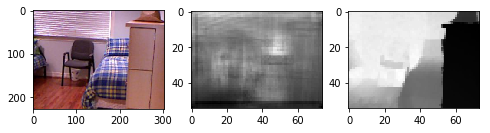

Train loss: 0.1211735638 Train accauacy: 0.41901578204 Test loss: 0.126995489234 Test acc: 0.419678096659
377.0 

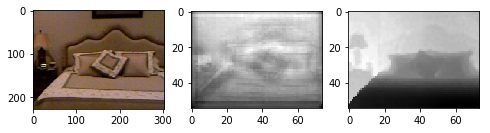

Train loss: 0.127399260551 Train accauacy: 0.396793613067 Test loss: 0.117023697123 Test acc: 0.412351235282
378.0 

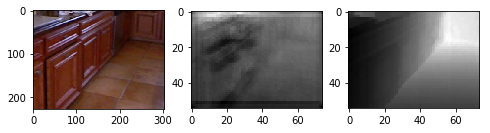

Train loss: 0.126534272129 Train accauacy: 0.400301690915 Test loss: 0.120064890943 Test acc: 0.444273073226
379.0 

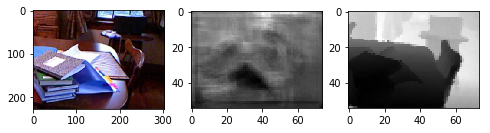

Train loss: 0.1250561364 Train accauacy: 0.410471792634 Test loss: 0.116561565315 Test acc: 0.430186574347
380.0 

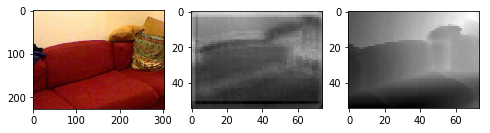

Train loss: 0.120465652673 Train accauacy: 0.421947884445 Test loss: 0.119178844034 Test acc: 0.416269961745
381.0 

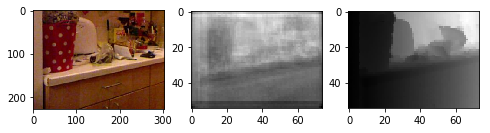

Train loss: 0.123539296136 Train accauacy: 0.401149121041 Test loss: 0.127062064246 Test acc: 0.417033936363
382.0 

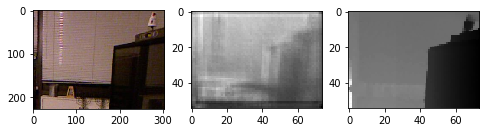

Train loss: 0.122924337393 Train accauacy: 0.408987432145 Test loss: 0.120115263388 Test acc: 0.430392926559
383.0 

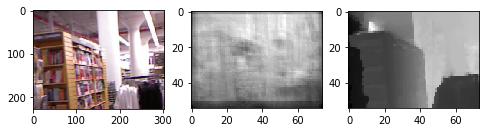

Train loss: 0.127326800416 Train accauacy: 0.390209790205 Test loss: 0.10692732106 Test acc: 0.442619396374
384.0 

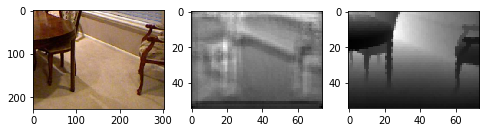

Train loss: 0.126840126801 Train accauacy: 0.39269419771 Test loss: 0.114316718653 Test acc: 0.435328047257
385.0 

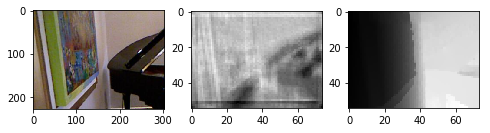

Train loss: 0.126010073005 Train accauacy: 0.407877527636 Test loss: 0.12585332687 Test acc: 0.384463299531
386.0 

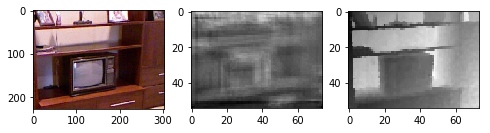

Train loss: 0.122245866318 Train accauacy: 0.409569079486 Test loss: 0.126940632705 Test acc: 0.38669379754
387.0 

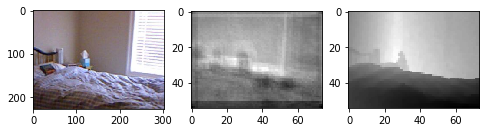

Train loss: 0.122077971296 Train accauacy: 0.42219641756 Test loss: 0.110292952508 Test acc: 0.430182735901
388.0 

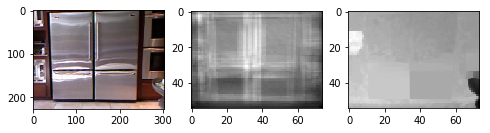

Train loss: 0.11853488463 Train accauacy: 0.420133717129 Test loss: 0.124057377689 Test acc: 0.408588952385
389.0 

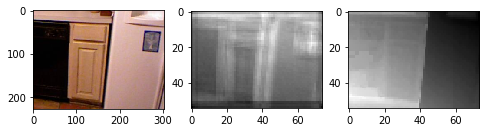

Train loss: 0.127167683553 Train accauacy: 0.407463144683 Test loss: 0.117200579261 Test acc: 0.423741746694
390.0 

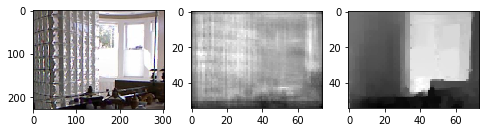

Train loss: 0.118826877397 Train accauacy: 0.411676195894 Test loss: 0.122621135553 Test acc: 0.431339257397
391.0 

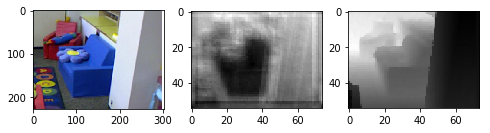

Train loss: 0.121308693061 Train accauacy: 0.417630174068 Test loss: 0.114982245257 Test acc: 0.446617783513
392.0 

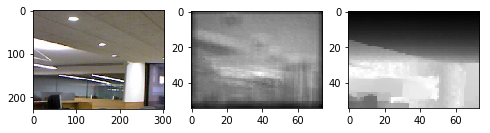

Train loss: 0.117695335786 Train accauacy: 0.417906587227 Test loss: 0.135539092356 Test acc: 0.397121662274
393.0 

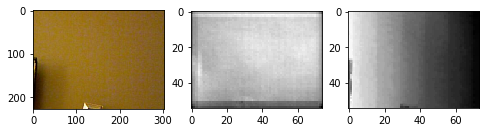

Train loss: 0.122697146266 Train accauacy: 0.406201332521 Test loss: 0.118872985011 Test acc: 0.435807928909
394.0 

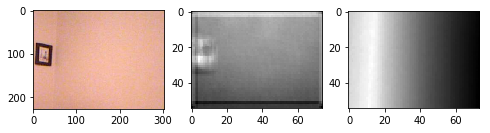

Train loss: 0.119209103888 Train accauacy: 0.408022113832 Test loss: 0.114793270361 Test acc: 0.434108182322
395.0 

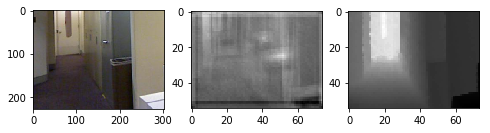

Train loss: 0.120179733921 Train accauacy: 0.41565370382 Test loss: 0.116662894259 Test acc: 0.4115623096
396.0 

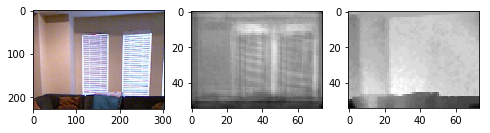

Train loss: 0.122765532365 Train accauacy: 0.419286052023 Test loss: 0.125160352793 Test acc: 0.382121467032
397.0 

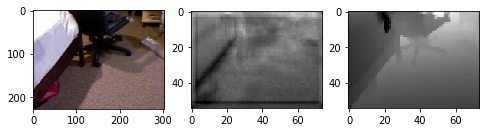

Train loss: 0.118582853818 Train accauacy: 0.409096817443 Test loss: 0.116851634113 Test acc: 0.441390895285
398.0 

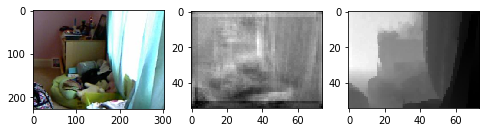

Train loss: 0.117715963664 Train accauacy: 0.420126629334 Test loss: 0.127930997871 Test acc: 0.385204236489
399.0 

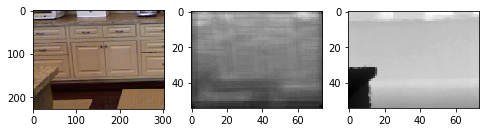

Train loss: 0.122787026688 Train accauacy: 0.41039194052 Test loss: 0.126106670825 Test acc: 0.402552020736
400.0 

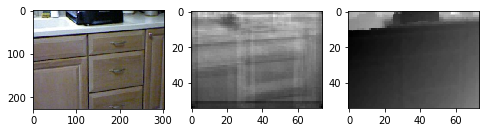

Train loss: 0.118929303122 Train accauacy: 0.410688197613 Test loss: 0.114600967267 Test acc: 0.427771806717
401.0 

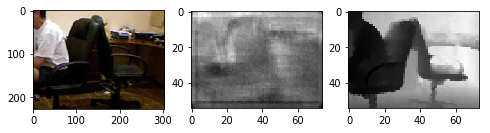

Train loss: 0.116087790521 Train accauacy: 0.427268710045 Test loss: 0.113013013732 Test acc: 0.436637167819
402.0 

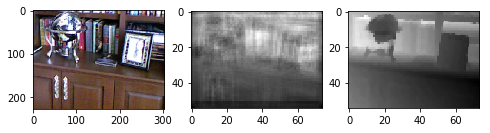

Train loss: 0.114311847091 Train accauacy: 0.426438055359 Test loss: 0.118119227118 Test acc: 0.427719018422
403.0 

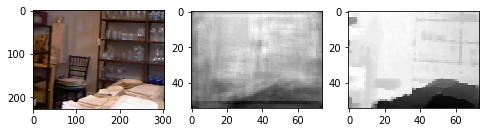

Train loss: 0.120434937984 Train accauacy: 0.408349082332 Test loss: 0.124962226604 Test acc: 0.409390359186
404.0 

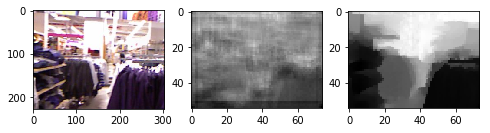

Train loss: 0.121832574933 Train accauacy: 0.41067095204 Test loss: 0.113366878359 Test acc: 0.416538697202
405.0 

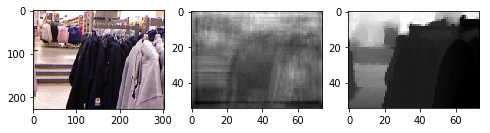

Train loss: 0.12140369421 Train accauacy: 0.409141939649 Test loss: 0.109024155186 Test acc: 0.449737024028
406.0 

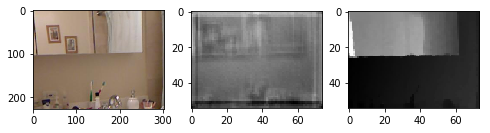

Train loss: 0.124333484414 Train accauacy: 0.416127149646 Test loss: 0.117667241837 Test acc: 0.410694682971
407.0 

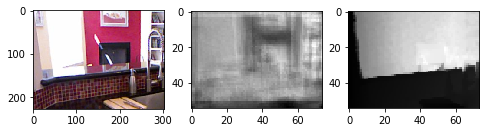

Train loss: 0.117809933023 Train accauacy: 0.415376819441 Test loss: 0.128934833105 Test acc: 0.388490481302
408.0 

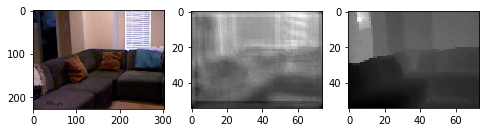

Train loss: 0.115567939413 Train accauacy: 0.425024332679 Test loss: 0.118224774953 Test acc: 0.427427251358
409.0 

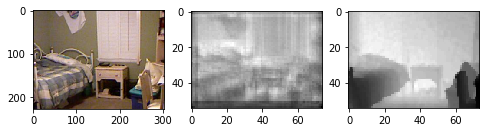

Train loss: 0.121354511065 Train accauacy: 0.40937299224 Test loss: 0.120459112572 Test acc: 0.415979154408
410.0 

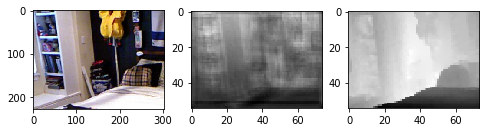

Train loss: 0.122733199138 Train accauacy: 0.410797579758 Test loss: 0.122798732948 Test acc: 0.391165348701
411.0 

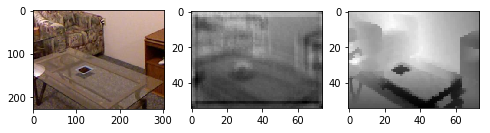

Train loss: 0.114800359251 Train accauacy: 0.41699773056 Test loss: 0.118539070245 Test acc: 0.401936805341
412.0 

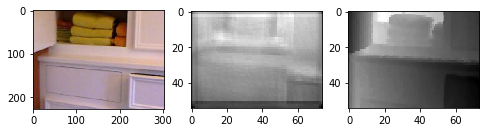

Train loss: 0.117692476969 Train accauacy: 0.421391986769 Test loss: 0.121863897657 Test acc: 0.43096975144
413.0 

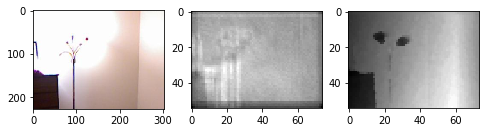

Train loss: 0.117430826191 Train accauacy: 0.428588641263 Test loss: 0.121966749895 Test acc: 0.425419418141
414.0 

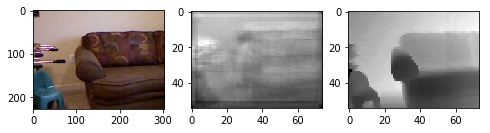

Train loss: 0.116066303792 Train accauacy: 0.420584010963 Test loss: 0.125007883529 Test acc: 0.404135635123
415.0 

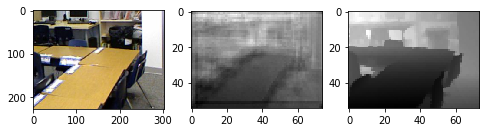

Train loss: 0.123719796997 Train accauacy: 0.407793423075 Test loss: 0.107812060742 Test acc: 0.437969322316
416.0 

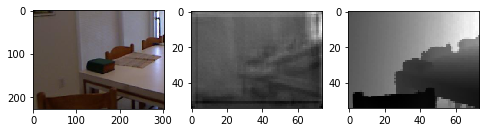

Train loss: 0.118312895499 Train accauacy: 0.41923384036 Test loss: 0.124049738748 Test acc: 0.411766739096
417.0 

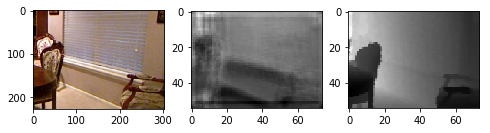

Train loss: 0.113837965635 Train accauacy: 0.432439755476 Test loss: 0.137927422067 Test acc: 0.377481953707
418.0 

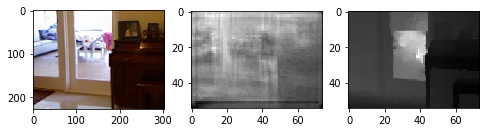

Train loss: 0.111813304201 Train accauacy: 0.434276364973 Test loss: 0.117139236885 Test acc: 0.420642657671
419.0 

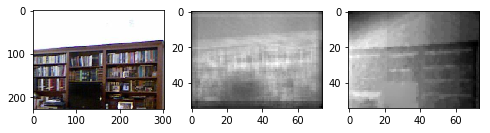

Train loss: 0.115309787742 Train accauacy: 0.428089917508 Test loss: 0.120920775924 Test acc: 0.416514702607
420.0 

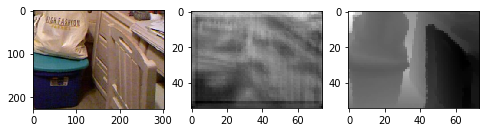

Train loss: 0.117218425813 Train accauacy: 0.410389811718 Test loss: 0.127363075735 Test acc: 0.403788194992
421.0 

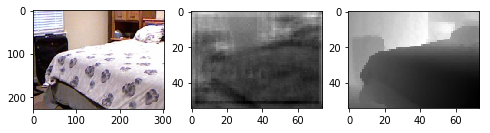

Train loss: 0.117731193482 Train accauacy: 0.413864344129 Test loss: 0.122901146999 Test acc: 0.404014701955
422.0 

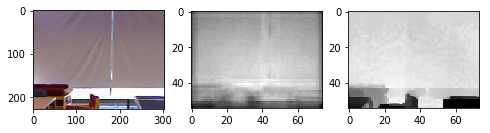

Train loss: 0.114892786225 Train accauacy: 0.429598848006 Test loss: 0.117881082231 Test acc: 0.434136977885
423.0 

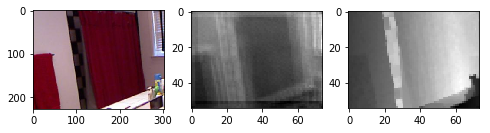

Train loss: 0.115561505522 Train accauacy: 0.422784680128 Test loss: 0.11373882764 Test acc: 0.440678744577
424.0 

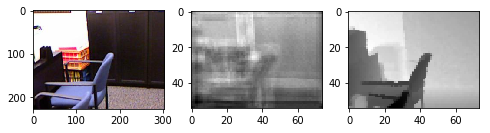

Train loss: 0.112981399865 Train accauacy: 0.432967067109 Test loss: 0.124775057659 Test acc: 0.400844596326
425.0 

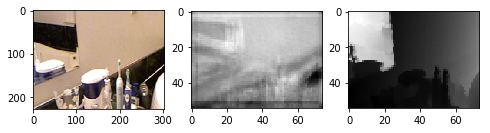

Train loss: 0.118421250324 Train accauacy: 0.420407532041 Test loss: 0.11809993675 Test acc: 0.430618471932
426.0 

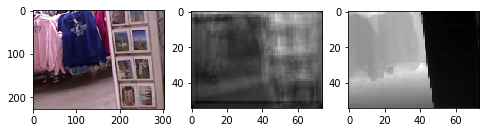

Train loss: 0.119227058584 Train accauacy: 0.410094971668 Test loss: 0.110469150008 Test acc: 0.405069486704
427.0 

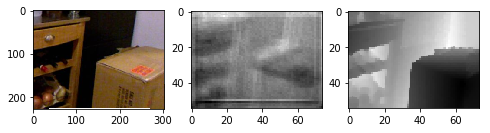

Train loss: 0.11762350534 Train accauacy: 0.426581223022 Test loss: 0.114469368011 Test acc: 0.413378182799
428.0 

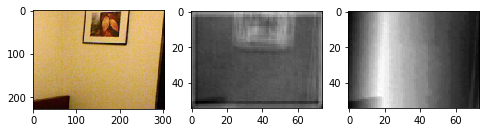

Train loss: 0.116477093244 Train accauacy: 0.415505574873 Test loss: 0.12214615033 Test acc: 0.391073210631
429.0 

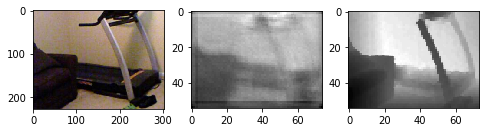

Train loss: 0.115157520284 Train accauacy: 0.41618006963 Test loss: 0.115468310658 Test acc: 0.420314419549
430.0 

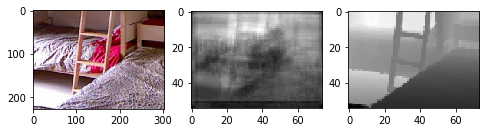

Train loss: 0.118695779603 Train accauacy: 0.421831884751 Test loss: 0.122325601056 Test acc: 0.428039584775
431.0 

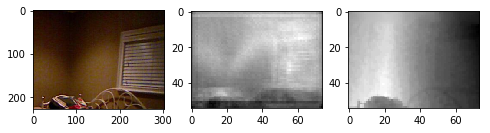

Train loss: 0.115401784503 Train accauacy: 0.42005835634 Test loss: 0.116384698078 Test acc: 0.433331728447
432.0 

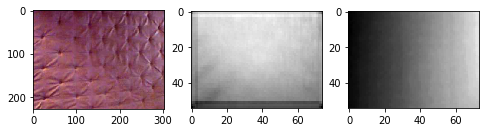

Train loss: 0.110263404995 Train accauacy: 0.435902474935 Test loss: 0.119027230656 Test acc: 0.417392889503
433.0 

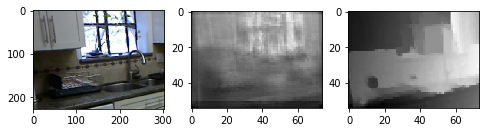

Train loss: 0.111130368652 Train accauacy: 0.439137687133 Test loss: 0.116565903183 Test acc: 0.424638170749
434.0 

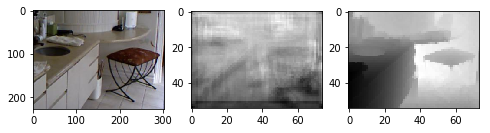

Train loss: 0.113529791253 Train accauacy: 0.42532980442 Test loss: 0.123945759377 Test acc: 0.409462338313
435.0 

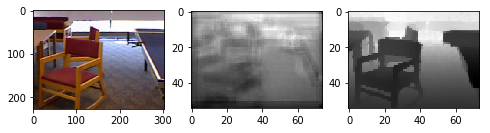

Train loss: 0.114668346712 Train accauacy: 0.434396616198 Test loss: 0.114580813097 Test acc: 0.429871778935
436.0 

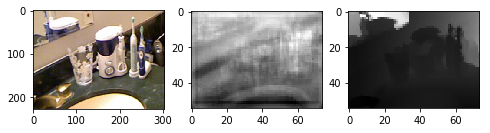

Train loss: 0.118638978497 Train accauacy: 0.420336420777 Test loss: 0.10990087199 Test acc: 0.446755989455
437.0 

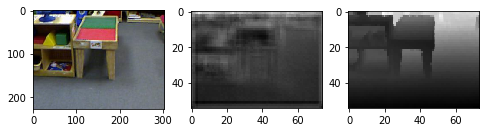

Train loss: 0.121486222543 Train accauacy: 0.417649781475 Test loss: 0.112599348999 Test acc: 0.420867245644
438.0 

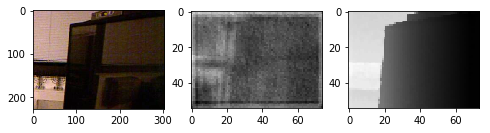

Train loss: 0.116526991014 Train accauacy: 0.41983391677 Test loss: 0.119686152437 Test acc: 0.383413316682
439.0 

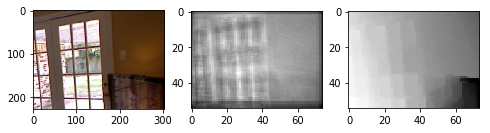

Train loss: 0.113841924157 Train accauacy: 0.431733132784 Test loss: 0.112167628598 Test acc: 0.439562540501
440.0 

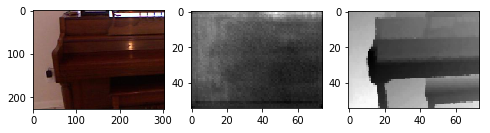

Train loss: 0.111452814707 Train accauacy: 0.428279863642 Test loss: 0.112066008965 Test acc: 0.439457923174
441.0 

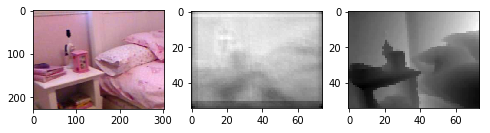

Train loss: 0.117792865147 Train accauacy: 0.422761764779 Test loss: 0.122557388153 Test acc: 0.419135828037
442.0 

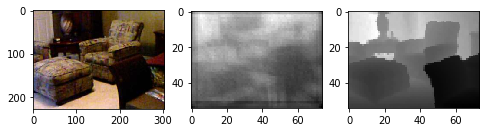

Train loss: 0.117153357972 Train accauacy: 0.421937488707 Test loss: 0.117816909449 Test acc: 0.412579665426
443.0 

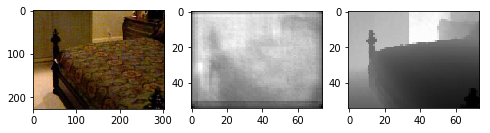

Train loss: 0.112509741376 Train accauacy: 0.437820118322 Test loss: 0.122492079856 Test acc: 0.419390158728
444.0 

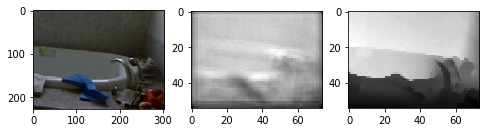

Train loss: 0.114670538415 Train accauacy: 0.429771783489 Test loss: 0.129136793781 Test acc: 0.410457618535
445.0 

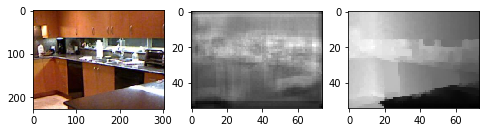

Train loss: 0.114739237668 Train accauacy: 0.42586774763 Test loss: 0.118460639962 Test acc: 0.431296069641
446.0 

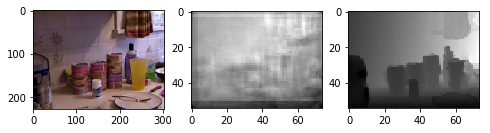

Train loss: 0.11561849762 Train accauacy: 0.422027734438 Test loss: 0.115729695768 Test acc: 0.413287011441
447.0 

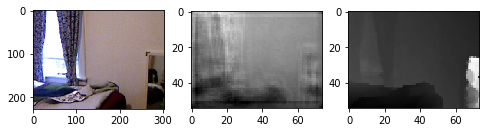

Train loss: 0.11681279136 Train accauacy: 0.418702985576 Test loss: 0.116692865733 Test acc: 0.393956349231
448.0 

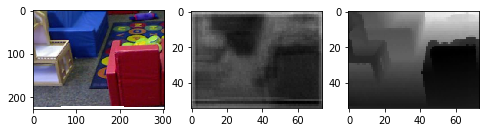

Train loss: 0.110423447822 Train accauacy: 0.445938858275 Test loss: 0.125939443475 Test acc: 0.394465985475
449.0 

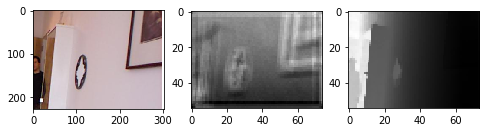

Train loss: 0.112608690646 Train accauacy: 0.430272396023 Test loss: 0.106520562316 Test acc: 0.398342480883
450.0 

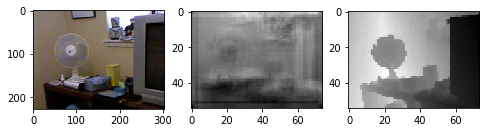

Train loss: 0.111798019134 Train accauacy: 0.436459318606 Test loss: 0.112256061751 Test acc: 0.428617362864
451.0 

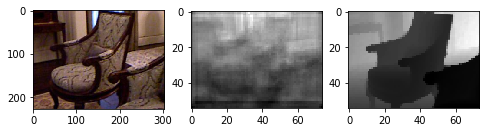

Train loss: 0.111489640176 Train accauacy: 0.435945708706 Test loss: 0.116680874373 Test acc: 0.428855381906
452.0 

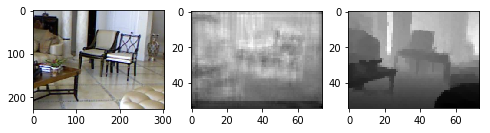

Train loss: 0.113269105181 Train accauacy: 0.420920902491 Test loss: 0.111915719463 Test acc: 0.42659609206
453.0 

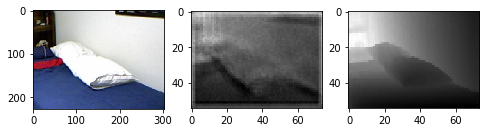

Train loss: 0.112002432375 Train accauacy: 0.433852767887 Test loss: 0.120079985121 Test acc: 0.410729228985
454.0 

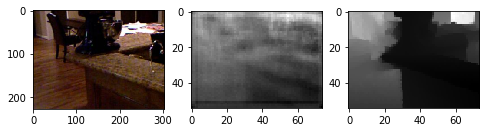

Train loss: 0.10783654096 Train accauacy: 0.44530381652 Test loss: 0.111035105772 Test acc: 0.430631911382
455.0 

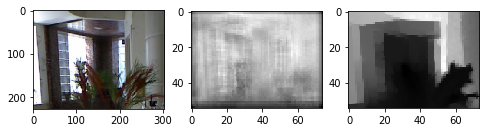

Train loss: 0.112364967196 Train accauacy: 0.437769089525 Test loss: 0.121780161746 Test acc: 0.391984993592
456.0 

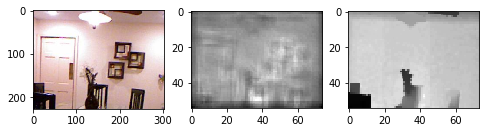

Train loss: 0.107428697755 Train accauacy: 0.43155830663 Test loss: 0.108825869975 Test acc: 0.42685715016
457.0 

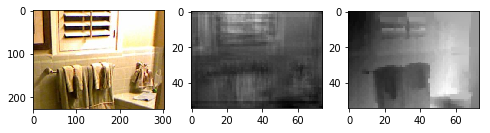

Train loss: 0.116547848886 Train accauacy: 0.421495226599 Test loss: 0.119760247879 Test acc: 0.407333576586
458.0 

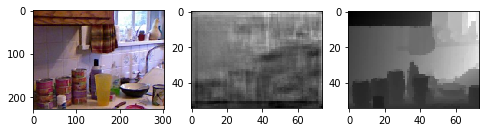

Train loss: 0.117613553858 Train accauacy: 0.419763985792 Test loss: 0.11055122409 Test acc: 0.40397151513
459.0 

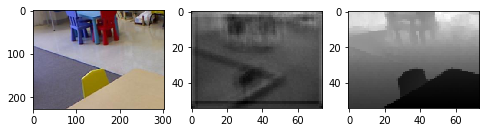

Train loss: 0.111071676904 Train accauacy: 0.438879228784 Test loss: 0.11782784143 Test acc: 0.411512398627
460.0 

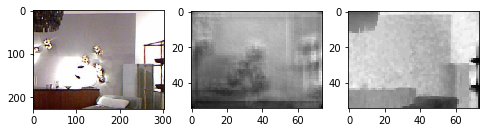

Train loss: 0.11073417079 Train accauacy: 0.436752503193 Test loss: 0.109751398209 Test acc: 0.433578391559
461.0 

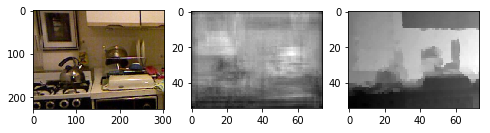

Train loss: 0.112591075181 Train accauacy: 0.426678321682 Test loss: 0.116416086792 Test acc: 0.41493012337
462.0 

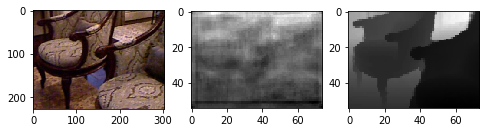

Train loss: 0.113146499458 Train accauacy: 0.421752740787 Test loss: 0.117288410198 Test acc: 0.423894346692
463.0 

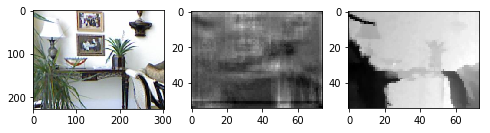

Train loss: 0.115000070488 Train accauacy: 0.430142931067 Test loss: 0.119332716917 Test acc: 0.408111948986
464.0 

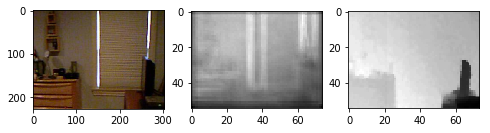

Train loss: 0.107369233009 Train accauacy: 0.438041013479 Test loss: 0.112336275168 Test acc: 0.407415159512
465.0 

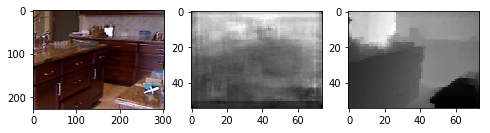

Train loss: 0.107032835455 Train accauacy: 0.434765876257 Test loss: 0.112829262041 Test acc: 0.428739252035
466.0 

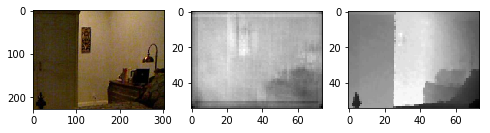

Train loss: 0.108382285272 Train accauacy: 0.44169131483 Test loss: 0.126043339027 Test acc: 0.382362368517
467.0 

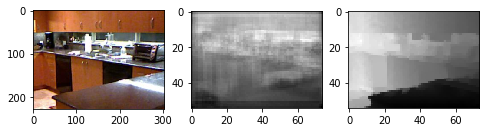

Train loss: 0.112495713165 Train accauacy: 0.430783404983 Test loss: 0.107278769836 Test acc: 0.446175330319
468.0 

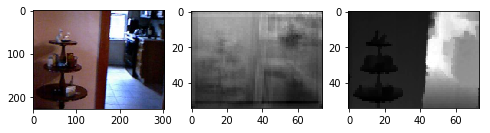

Train loss: 0.114862079718 Train accauacy: 0.426144869855 Test loss: 0.116769879125 Test acc: 0.421562113333
469.0 

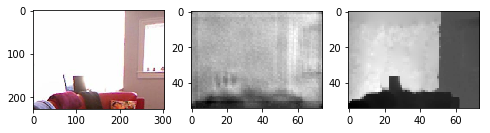

Train loss: 0.109413459696 Train accauacy: 0.445769705337 Test loss: 0.121298965765 Test acc: 0.401811079588
470.0 

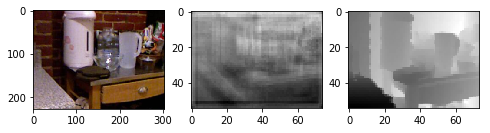

Train loss: 0.109095330164 Train accauacy: 0.439319127225 Test loss: 0.11172112776 Test acc: 0.416637553833
471.0 

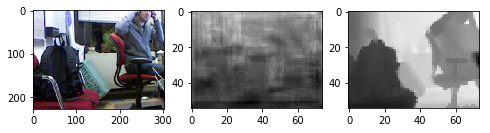

Train loss: 0.110799128132 Train accauacy: 0.434125639326 Test loss: 0.110886556562 Test acc: 0.419602271635
472.0 

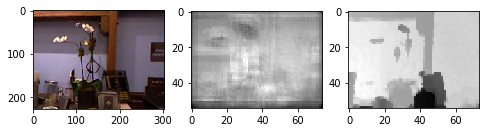

Train loss: 0.113043560116 Train accauacy: 0.424740360333 Test loss: 0.11715930549 Test acc: 0.428985909559
473.0 

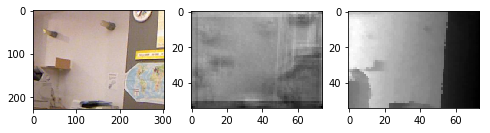

Train loss: 0.11094994055 Train accauacy: 0.434064211295 Test loss: 0.113090421073 Test acc: 0.42520251032
474.0 

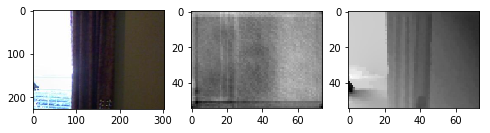

Train loss: 0.107933202644 Train accauacy: 0.449493007706 Test loss: 0.1151528185 Test acc: 0.410069870763
475.0 

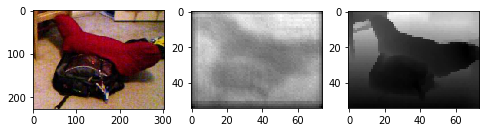

Train loss: 0.10779094527 Train accauacy: 0.445938147604 Test loss: 0.129941204097 Test acc: 0.402816911694
476.0 

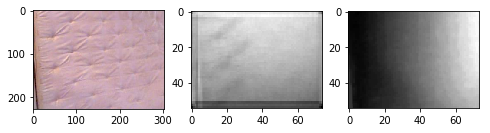

Train loss: 0.109728110324 Train accauacy: 0.430564875098 Test loss: 0.116506040795 Test acc: 0.419352731667
477.0 

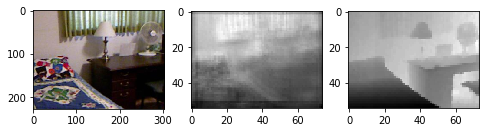

Train loss: 0.106930785884 Train accauacy: 0.443940182374 Test loss: 0.116541320109 Test acc: 0.410624618642
478.0 

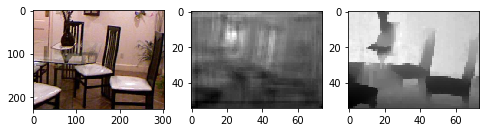

Train loss: 0.110790739524 Train accauacy: 0.429722405855 Test loss: 0.11325828603 Test acc: 0.419831656851
479.0 

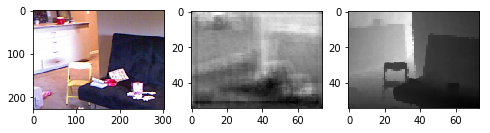

Train loss: 0.109498391214 Train accauacy: 0.436506332228 Test loss: 0.109934807057 Test acc: 0.418622351717
480.0 

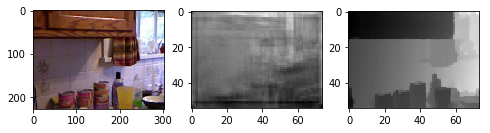

Train loss: 0.108280508736 Train accauacy: 0.441301975055 Test loss: 0.123490753351 Test acc: 0.40247427905
481.0 

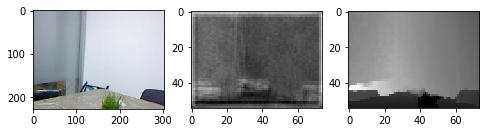

Train loss: 0.106228447476 Train accauacy: 0.440100168265 Test loss: 0.109405634925 Test acc: 0.416404328775
482.0 

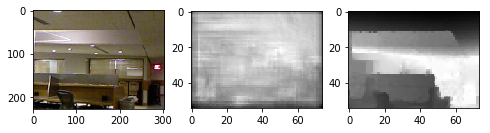

Train loss: 0.111491090002 Train accauacy: 0.435221838951 Test loss: 0.112399316626 Test acc: 0.441608758643
483.0 

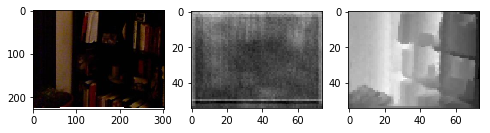

Train loss: 0.112314953368 Train accauacy: 0.430820733481 Test loss: 0.109793213895 Test acc: 0.421909547877
484.0 

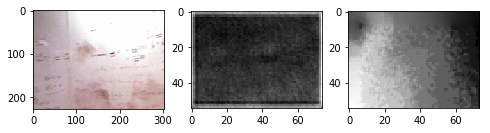

Train loss: 0.107963450024 Train accauacy: 0.445742061849 Test loss: 0.120178999845 Test acc: 0.386459618807
485.0 

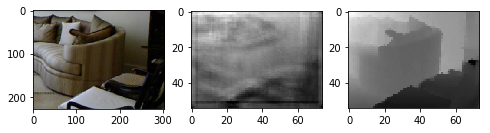

Train loss: 0.107597175326 Train accauacy: 0.450700481465 Test loss: 0.111778792343 Test acc: 0.448259943165
486.0 

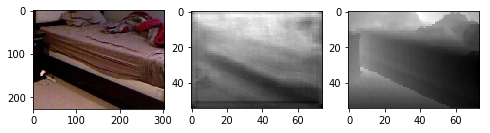

Train loss: 0.108167008167 Train accauacy: 0.438801265565 Test loss: 0.135801526485 Test acc: 0.398954813834
487.0 

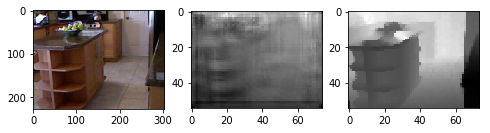

Train loss: 0.105822237868 Train accauacy: 0.44927069476 Test loss: 0.118010946782 Test acc: 0.428302557208
488.0 

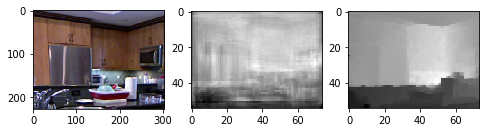

Train loss: 0.114918392381 Train accauacy: 0.426913862503 Test loss: 0.118941479595 Test acc: 0.405874732882
489.0 

In [ ]:
from datetime import datetime
now = datetime.now()

Nth_RUN = 'BN_FCRN_augment_depth_0003'
training_epochs=1000
logs_path = './logs/{}'.format(Nth_RUN)
saver = tf.train.Saver()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    tf.global_variables_initializer().run(session=sess)
    tf.local_variables_initializer().run(session=sess)
    latest_ckpt = tf.train.latest_checkpoint(logs_path)
    if latest_ckpt:
        saver.restore(sess, latest_ckpt)
        print('Checkpoint recovered', latest_ckpt)
    summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
    # start queue loader (for data)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord = coord)
    # Training cycle
    training_coarse = 2
    while sess.run(tf.assign_add(global_step, 1)) < training_epochs:
        print(sess.run(global_step), end=' ')
        train_loss = 0
        train_accu = 0
        for s in range(130):
            batch_img, batch_depth = sess.run([train_imgs, train_depths])
            _, cur_loss, cur_accu = sess.run([train_op, loss_op, accuracy_op], feed_dict={img_input:batch_img, 
                                                           depth_input:batch_depth, 
                                                           fine_gate:not training_coarse, 
                                                           is_training:True})
            training_coarse = training_coarse-1
            if training_coarse<0:
                training_coarse = 2
            train_loss += cur_loss/130
            train_accu += cur_accu/130
            
        I,D = sess.run([train_imgs, train_depths])
        C,O = sess.run([coarse_output, refined_output], feed_dict={img_input:I, depth_input:D, is_training:False})
    
        summary_writer.add_summary(
            sess.run(train_summary, 
                     feed_dict={
                         running_loss_sum:train_loss,
                         running_accuracy_sum:train_accu,
                         input_image_sum:I[-1:,...], 
                         input_depth_sum:D[-1:,...], 
                         coarse_sum:C[-1:,...], 
                         refined_sum:O[-1:,...]}), global_step=sess.run(global_step))
        
        test_loss = 0
        test_accu = 0
        for s in range(32):
            tbatch_img, tbatch_depth = sess.run([test_imgs, test_depths])
            cur_loss, cur_accu = sess.run([loss_op, accuracy_op], 
                                  feed_dict={
                                      img_input:tbatch_img,
                                      depth_input:tbatch_depth,
                                      is_training:False})
            test_loss += cur_loss/32
            test_accu += cur_accu/32
        TI, TD = sess.run([test_imgs, test_depths])
        TC, TO = sess.run([coarse_output, refined_output], feed_dict={img_input:TI,depth_input:TD, is_training:False})
        plt.figure(figsize=(8, 6))
        plt.subplot(131)
        test_in = normalize(TI[1])
        plt.imshow(np.reshape(test_in,[test_in.shape[0],test_in.shape[1],3]))
           
        plt.subplot(132)
        pred = normalize(np.exp(TO[1]))
        
        plt.imshow(np.reshape(pred,[pred.shape[0],pred.shape[1]]),cmap='gray')
        plt.subplot(133)
        target = normalize(np.exp(TD[1]))
        plt.imshow(np.reshape(target,[target.shape[0],target.shape[1]]),cmap = 'gray')
        plt.show()
        summary_writer.add_summary(
            sess.run(test_summary, 
                     feed_dict={
                         running_loss_sum:test_loss, 
                         running_accuracy_sum:cur_accu,
                         input_image_sum:TI[-1:,...], 
                         input_depth_sum:TD[-1:,...], 
                         coarse_sum:TC[-1:,...], 
                         refined_sum:TO[-1:,...]}), global_step=sess.run(global_step))
        print('Train loss: ' + str(train_loss) + ' Train accauacy: '+ str(train_accu)+' Test loss: ' + str(test_loss)+ ' Test acc: '+ str(test_accu)) 
        if sess.run(global_step)%10==0:
            save_path = saver.save(sess, logs_path+"/CSE291FinalModel.ckpt", global_step=global_step)  #save model for second part
    # end queue loader
    coord.request_stop()
    coord.join(threads)

In [ ]:
compile()